In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
import jax.random as jax_random
import pandas as pd

import keras
from keras import models
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import ops

In [2]:
import torchvision
from torch.utils.data import Dataset, DataLoader

In [3]:
plt.set_loglevel("info")

In [4]:
print(f"Keras: {keras.__version__}")

Keras: 3.6.0


In [5]:
epochs = 50  # 50 epochs of training
B = 256  # a respectable average batch size

to_numpy_array = lambda img: np.array(img, dtype=np.float32) / 255.0

train_data = torchvision.datasets.FashionMNIST(
    "./data", train=True, transform=to_numpy_array, download=True
)
test_data = torchvision.datasets.FashionMNIST(
    "./data", train=False, transform=to_numpy_array, download=True
)

train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B)

In [6]:
eta_0 = 0.1

# How many values are in the input? We use this to help determine the size of subsequent layers
D = 28 * 28  # 28 * 28 images
# Hidden layer size
n = 128
# How many channels are in the input?
C = 1
# How many classes are there?
classes = 10

# fc_model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(D,  n),
#     nn.Tanh(),
#     nn.Linear(n,  n),
#     nn.Tanh(),
#     nn.Linear(n,  n),
#     nn.Tanh(),
#     nn.Linear(n, classes),
# )


def get_fc_model():
    return models.Sequential(
        [
            layers.Input(shape=(28, 28)),
            layers.Flatten(),
            layers.Dense(n, activation="tanh"),
            layers.Dense(n, activation="tanh"),
            layers.Dense(n, activation="tanh"),
            layers.Dense(classes, activation="softmax"),
        ]
    )


fc_model = get_fc_model()

fc_model.compile(
    optimizer=optimizers.SGD(learning_rate=eta_0),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

In [7]:
fc_model_result = fc_model.fit(train_loader, epochs=epochs, validation_data=test_loader)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8933 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.6086 - val_sparse_categorical_accuracy: 0.7767
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4832 - sparse_categorical_accuracy: 0.8220 - val_loss: 0.5447 - val_sparse_categorical_accuracy: 0.8056
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4350 - sparse_categorical_accuracy: 0.8447 - val_loss: 0.5600 - val_sparse_categorical_accuracy: 0.7785
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4288 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.4898 - val_sparse_categorical_accuracy: 0.8117
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3892 - sparse_categorical_accuracy: 0.8594 - val_loss: 0.4453 - val_sparse_categorical_accuracy: 0.8419
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3815 - sparse_categorical_accuracy: 0.8615 - val_loss: 0.4373 - val_sparse_categorical_accuracy: 0.8459
Epoc

<Axes: >

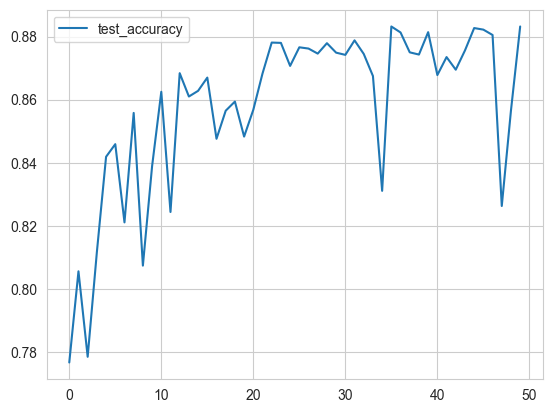

In [8]:
pd.DataFrame(
    {"test_accuracy": fc_model_result.history["val_sparse_categorical_accuracy"]}
).plot()

0.954992586021436


Text(0, 0.5, 'Learning Rate')

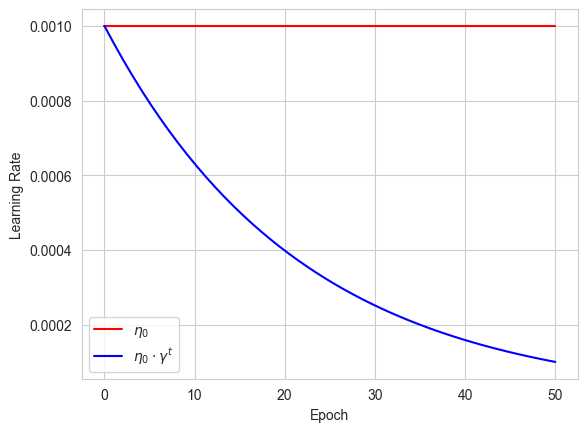

In [9]:
T = 50  # total epochs
epochs_input = np.linspace(0, 50, num=50)  # generating all of the different t values
eta_init = 0.001  # pretend initial learning rate $\eta_0$
eta_min = 0.0001  # pretend desired minimum learning rate $\eta_{\mathit{min}}$
gamma = np.power(eta_min / eta_init, 1.0 / T)  # Compute the decay rate $\gamma$
print(gamma)
effective_learning_rate = eta_init * np.power(
    gamma, epochs_input
)  # all of the $\eta_t$ values

sns.lineplot(x=epochs_input, y=eta_init, color="red", label="$\\eta_0$")
ax = sns.lineplot(
    x=epochs_input,
    y=effective_learning_rate,
    color="blue",
    label="$\\eta_0 \\cdot \\gamma^t$",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")

In [10]:
fc_model = get_fc_model()

eta_min = 0.0001  # Our desired final learning rate $\eta_{\mathit{min}}$

gamma_expo = (eta_min/eta_0)**(1/epochs)#compute $\gamma$ that results in $\eta_{\mathit{min}}$

scheduler = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=eta_0, decay_rate=gamma, decay_steps=T, staircase=True
)
optimizer = optimizers.SGD(learning_rate=scheduler)  # Set up the optimizer
# train like normal and pass along the desired optimizer and schedule

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_expo_decay_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, verbose=2
)

Epoch 1/50
235/235 - 2s - 8ms/step - loss: 0.6598 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.5510 - val_sparse_categorical_accuracy: 0.7996
Epoch 2/50
235/235 - 1s - 6ms/step - loss: 0.4667 - sparse_categorical_accuracy: 0.8312 - val_loss: 0.4788 - val_sparse_categorical_accuracy: 0.8281
Epoch 3/50
235/235 - 1s - 5ms/step - loss: 0.4251 - sparse_categorical_accuracy: 0.8475 - val_loss: 0.4449 - val_sparse_categorical_accuracy: 0.8402
Epoch 4/50
235/235 - 1s - 5ms/step - loss: 0.4025 - sparse_categorical_accuracy: 0.8560 - val_loss: 0.4757 - val_sparse_categorical_accuracy: 0.8244
Epoch 5/50
235/235 - 1s - 5ms/step - loss: 0.3885 - sparse_categorical_accuracy: 0.8611 - val_loss: 0.4278 - val_sparse_categorical_accuracy: 0.8471
Epoch 6/50
235/235 - 1s - 5ms/step - loss: 0.3783 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.4198 - val_sparse_categorical_accuracy: 0.8479
Epoch 7/50
235/235 - 1s - 5ms/step - loss: 0.3707 - sparse_categorical_accuracy: 0.8675 - val_loss: 0.4238

In [11]:
print(gamma_expo)

0.8709635899560806


<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:12: SyntaxWarning: invalid escape sequence '\e'
/var/folders/91/q7s25zm95b12hy2_c63x36zh0000gn/T/ipykernel_1692/1814760927.py:1: SyntaxWarning: invalid escape sequence '\e'
  sns.lineplot(x=epochs_input, y=eta_init, color="red", label="$\eta_0$")
/var/folders/91/q7s25zm95b12hy2_c63x36zh0000gn/T/ipykernel_1692/1814760927.py:12: SyntaxWarning: invalid escape sequence '\e'
  label="$\eta_0 \cdot \gamma^t$",


Text(0, 0.5, 'Learning Rate')

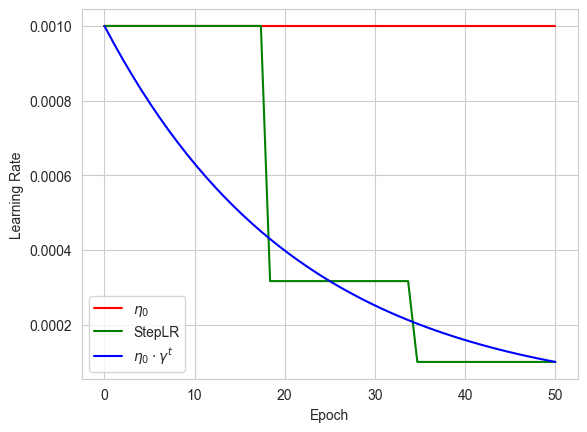

In [12]:
sns.lineplot(x=epochs_input, y=eta_init, color="red", label="$\eta_0$")
sns.lineplot(
    x=epochs_input,
    y=[eta_init] * 18 + [eta_init / 3.16] * 16 + [eta_init / 10] * 16,
    color="green",
    label="StepLR",
)
ax = sns.lineplot(
    x=epochs_input,
    y=effective_learning_rate,
    color="blue",
    label="$\eta_0 \cdot \gamma^t$",
)
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")

In [13]:
fc_model = get_fc_model()

values = list(sorted(set([eta_init]*18+[eta_init/3.16]*16+[eta_init/10]*16))) + [0.001]
boundaries = [18, 18+16, 18+16*2]
scheduler = optimizers.schedules.PiecewiseConstantDecay(
    boundaries=boundaries, values=values
)
optimizer = optimizers.SGD(learning_rate=scheduler)

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_steplr_decay_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, verbose=2
)

Epoch 1/50
235/235 - 2s - 8ms/step - loss: 2.1619 - sparse_categorical_accuracy: 0.2492 - val_loss: 1.8855 - val_sparse_categorical_accuracy: 0.4316
Epoch 2/50
235/235 - 1s - 6ms/step - loss: 1.7097 - sparse_categorical_accuracy: 0.5057 - val_loss: 1.5724 - val_sparse_categorical_accuracy: 0.5593
Epoch 3/50
235/235 - 1s - 5ms/step - loss: 1.4604 - sparse_categorical_accuracy: 0.5973 - val_loss: 1.3758 - val_sparse_categorical_accuracy: 0.6115
Epoch 4/50
235/235 - 1s - 5ms/step - loss: 1.2963 - sparse_categorical_accuracy: 0.6302 - val_loss: 1.2410 - val_sparse_categorical_accuracy: 0.6339
Epoch 5/50
235/235 - 1s - 5ms/step - loss: 1.1803 - sparse_categorical_accuracy: 0.6482 - val_loss: 1.1433 - val_sparse_categorical_accuracy: 0.6474
Epoch 6/50
235/235 - 1s - 5ms/step - loss: 1.0939 - sparse_categorical_accuracy: 0.6617 - val_loss: 1.0690 - val_sparse_categorical_accuracy: 0.6572
Epoch 7/50
235/235 - 1s - 5ms/step - loss: 1.0269 - sparse_categorical_accuracy: 0.6725 - val_loss: 1.0102

In [14]:
list(sorted(set([eta_init]*18+[eta_init/3.16]*16+[eta_init/10]*16)))

[0.0001, 0.00031645569620253165, 0.001]

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\e'
/var/folders/91/q7s25zm95b12hy2_c63x36zh0000gn/T/ipykernel_1692/4181069845.py:3: SyntaxWarning: invalid escape sequence '\e'
  sns.lineplot(x=epochs_input, y=eta_init, color='red', label="$\eta_0$")
/var/folders/91/q7s25zm95b12hy2_c63x36zh0000gn/T/ipykernel_1692/4181069845.py:4: SyntaxWarning: invalid escape sequence '\c'
  sns.lineplot(x=epochs_input, y=cos_lr, color='purple', label="$\cos$")
/var/folders/91/q7s25zm95b12hy2_c63x36zh0000gn/T/ipykernel_1692/4181069845.py:6: SyntaxWarning: invalid escape sequence '\e'
  ax = sns.lineplot(x=epochs_input, y=effective_learning_rate, color='blue', label="$\eta_0 \cdot \gamma^t$")


Text(0, 0.5, 'Learning Rate')

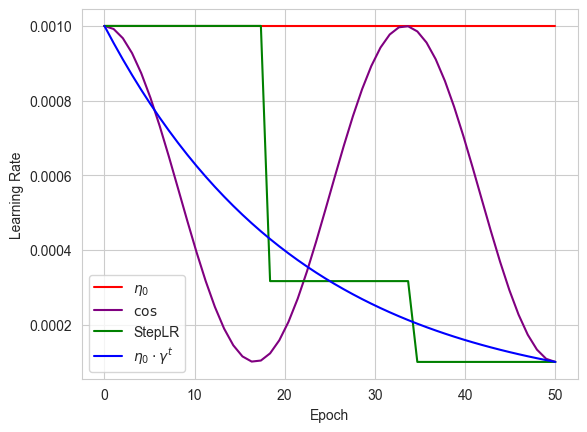

In [15]:
cos_lr = eta_min + 0.5*(eta_init-eta_min)*(1+np.cos(epochs_input/(T/3.0)*np.pi))#computes the cosine schedule $\eta_t$ for every value of $t$ 

sns.lineplot(x=epochs_input, y=eta_init, color='red', label="$\eta_0$")
sns.lineplot(x=epochs_input, y=cos_lr, color='purple', label="$\cos$")
sns.lineplot(x=epochs_input, y=[eta_init]*18+[eta_init/3.16]*16+[eta_init/10]*16, color='green', label="StepLR")
ax = sns.lineplot(x=epochs_input, y=effective_learning_rate, color='blue', label="$\eta_0 \cdot \gamma^t$")
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')

In [34]:
fc_model = get_fc_model()

decay_steps = 50 / 3
initial_learning_rate = 1.
scheduler = optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps, alpha=1e-4
)

optimizer = optimizers.SGD(learning_rate=scheduler)

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_cosine_decay_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, verbose=2
)

Epoch 1/50
235/235 - 2s - 8ms/step - loss: 11.4224 - sparse_categorical_accuracy: 0.1026 - val_loss: 11.6112 - val_sparse_categorical_accuracy: 0.1041
Epoch 2/50
235/235 - 1s - 6ms/step - loss: 11.6112 - sparse_categorical_accuracy: 0.1070 - val_loss: 11.6111 - val_sparse_categorical_accuracy: 0.1055
Epoch 3/50
235/235 - 1s - 5ms/step - loss: 11.6111 - sparse_categorical_accuracy: 0.1083 - val_loss: 11.6111 - val_sparse_categorical_accuracy: 0.1079
Epoch 4/50
235/235 - 1s - 6ms/step - loss: 11.6110 - sparse_categorical_accuracy: 0.1122 - val_loss: 11.6110 - val_sparse_categorical_accuracy: 0.1112
Epoch 5/50
235/235 - 1s - 5ms/step - loss: 11.6110 - sparse_categorical_accuracy: 0.1103 - val_loss: 11.6110 - val_sparse_categorical_accuracy: 0.1038
Epoch 6/50
235/235 - 1s - 5ms/step - loss: 11.6110 - sparse_categorical_accuracy: 0.1114 - val_loss: 11.6110 - val_sparse_categorical_accuracy: 0.0992
Epoch 7/50
235/235 - 1s - 5ms/step - loss: 11.6109 - sparse_categorical_accuracy: 0.1008 - val

<Axes: >

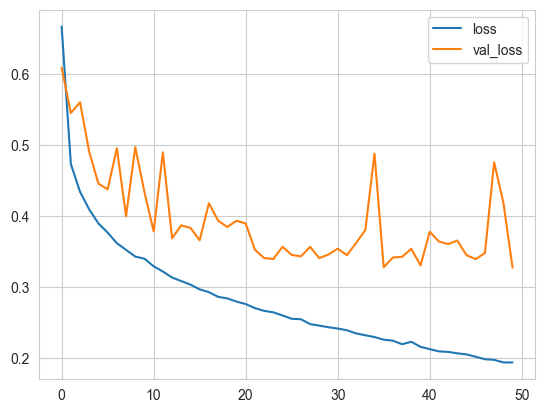

In [17]:
pd.DataFrame(fc_model_result.history)[["loss", "val_loss"]].plot()

In [18]:
fc_model = get_fc_model()

optimizer = optimizers.SGD(learning_rate=eta_0)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10)
fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_reducelr_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader, callbacks=reduce_lr
)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9033 - sparse_categorical_accuracy: 0.6928 - val_loss: 0.5206 - val_sparse_categorical_accuracy: 0.8121 - learning_rate: 0.1000
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4979 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.5583 - val_sparse_categorical_accuracy: 0.7875 - learning_rate: 0.1000
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4380 - sparse_categorical_accuracy: 0.8401 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.7367 - learning_rate: 0.1000
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4182 - sparse_categorical_accuracy: 0.8479 - val_loss: 0.5037 - val_sparse_categorical_accuracy: 0.8181 - learning_rate: 0.1000
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3981 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.4249 - val_sparse_categorical_accuracy: 0.8457 - learning_rate: 0.1000
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

# SGD vs SGD Momentum, Nesterov Momentum

In [48]:
fc_model = get_fc_model()

optimizer = optimizers.SGD(learning_rate=1e-1, momentum=0.9, nesterov=False)

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_momentum_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader
)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7428 - sparse_categorical_accuracy: 0.7259 - val_loss: 0.4269 - val_sparse_categorical_accuracy: 0.8419
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4022 - sparse_categorical_accuracy: 0.8517 - val_loss: 0.3878 - val_sparse_categorical_accuracy: 0.8573
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3549 - sparse_categorical_accuracy: 0.8675 - val_loss: 0.3730 - val_sparse_categorical_accuracy: 0.8622
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3327 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.3690 - val_sparse_categorical_accuracy: 0.8648
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3153 - sparse_categorical_accuracy: 0.8798 - val_loss: 0.3884 - val_sparse_categorical_accuracy: 0.8590
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2997 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.3857 - val_sparse_categorical_accuracy: 0.8591
Epoc

In [47]:
fc_model = get_fc_model()

optimizer = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_nesterov_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader
)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7083 - sparse_categorical_accuracy: 0.7323 - val_loss: 0.4566 - val_sparse_categorical_accuracy: 0.8337
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3789 - sparse_categorical_accuracy: 0.8579 - val_loss: 0.4230 - val_sparse_categorical_accuracy: 0.8431
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3382 - sparse_categorical_accuracy: 0.8760 - val_loss: 0.4027 - val_sparse_categorical_accuracy: 0.8538
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3084 - sparse_categorical_accuracy: 0.8831 - val_loss: 0.3928 - val_sparse_categorical_accuracy: 0.8563
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2970 - sparse_categorical_accuracy: 0.8897 - val_loss: 0.3555 - val_sparse_categorical_accuracy: 0.8739
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2685 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.3768 - val_sparse_categorical_accuracy: 0.8618
Epoc

<Axes: >

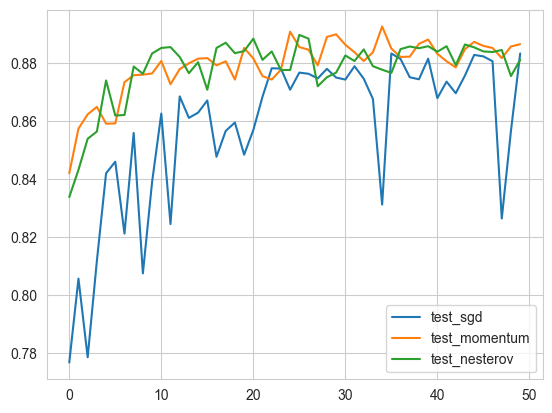

In [49]:
pd.DataFrame({
    "test_sgd": fc_model_result.history["val_sparse_categorical_accuracy"],
    "test_momentum": fc_model_momentum_result.history["val_sparse_categorical_accuracy"],
    "test_nesterov": fc_model_nesterov_result.history["val_sparse_categorical_accuracy"]
}).plot()

In [50]:
fc_model = get_fc_model()

optimizer = optimizers.AdamW()

fc_model.compile(
    optimizer=optimizer,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

fc_model_adamw_result = fc_model.fit(
    train_loader, epochs=epochs, validation_data=test_loader
)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7648 - sparse_categorical_accuracy: 0.7362 - val_loss: 0.4332 - val_sparse_categorical_accuracy: 0.8461
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3869 - sparse_categorical_accuracy: 0.8595 - val_loss: 0.4037 - val_sparse_categorical_accuracy: 0.8539
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3520 - sparse_categorical_accuracy: 0.8721 - val_loss: 0.3912 - val_sparse_categorical_accuracy: 0.8560
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3318 - sparse_categorical_accuracy: 0.8773 - val_loss: 0.3663 - val_sparse_categorical_accuracy: 0.8678
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3082 - sparse_categorical_accuracy: 0.8870 - val_loss: 0.3494 - val_sparse_categorical_accuracy: 0.8751
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2917 - sparse_categorical_accuracy: 0.8919 - val_loss: 0.3435 - val_sparse_categorical_accuracy: 0.8725
Epoc

<Axes: >

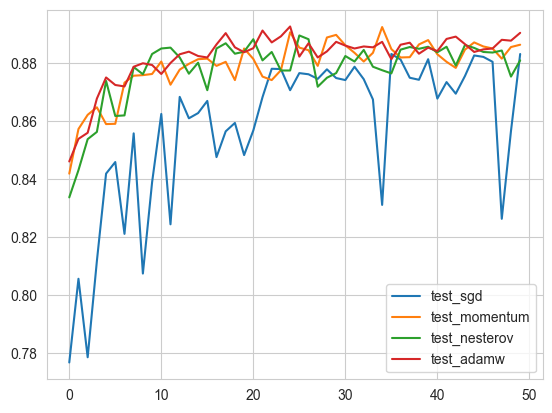

In [51]:
pd.DataFrame({
    "test_sgd": fc_model_result.history["val_sparse_categorical_accuracy"],
    "test_momentum": fc_model_momentum_result.history["val_sparse_categorical_accuracy"],
    "test_nesterov": fc_model_nesterov_result.history["val_sparse_categorical_accuracy"],
    "test_adamw": fc_model_adamw_result.history["val_sparse_categorical_accuracy"]
    
}).plot()